## RNN chat generator

In [115]:
import re
import glob
import os
import numpy as np

import nltk
nltk.download('punkt')

from nltk import word_tokenize
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
ChineseFont = FontProperties(fname='C:\\Windows\\Fonts\\simsun.ttc')

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\issohl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Import

https://childes.talkbank.org/access/Biling/Singapore.html

In [116]:
text = []

def extract_text(lines):
    # conversations start with something like this:
    # *TIF:\tsomething

    # strip out anything within square brackets
    filtered = [re.sub(r'\[.*\]', '' , l) for l in lines if l.startswith('*')]
    
    # strip out speaker
    filtered = [re.sub(r'\*(.*):\t', '' , l) for l in filtered]

    # replace some characters with space
    filtered = [re.sub(r'[_]', ' ' , l) for l in filtered]

    # remove some characters
    filtered = [re.sub(r'[#@\(\)&?!.,;:<>]', '' , l) for l in filtered]
    
    return filtered

for filename in glob.iglob('Singapore/*.cha', recursive=True):
    # print(filename)
    lines = open(filename, encoding='utf-8', errors='ignore').read().split('\n')
    text += extract_text(lines)
    
print('raw text count:', len(text))

raw text count: 43734


In [117]:
# count max text length
counts = [len(t) for t in text]
max_length = int(np.array(counts).max())
mean_length = int(np.array(counts).mean())

print('max text length', max_length)
print('mean text length', mean_length)

max text length 67
mean text length 19


## Train Word2Vec

In [118]:
tokens = []
for l in text:
    candidates = [t.lower() for t in word_tokenize(l) if len(t) > 0]
    if len(candidates) > 0:
        tokens.append(candidates)

In [119]:
vector_size=200
window_size=5

# train
word2vec = Word2Vec(tokens, size=vector_size, window=window_size,
                    min_count=3, workers=4)

word2vec.wv.vocab

{'www': <gensim.models.keyedvectors.Vocab at 0x1a9aa996978>,
 'yyy': <gensim.models.keyedvectors.Vocab at 0x1a9aa996780>,
 'xxx': <gensim.models.keyedvectors.Vocab at 0x1a9aa996198>,
 'lea': <gensim.models.keyedvectors.Vocab at 0x1a9aa996240>,
 'you': <gensim.models.keyedvectors.Vocab at 0x1a9aa9964a8>,
 'go': <gensim.models.keyedvectors.Vocab at 0x1a9aa996b38>,
 'to': <gensim.models.keyedvectors.Vocab at 0x1a9aa996630>,
 'your': <gensim.models.keyedvectors.Vocab at 0x1a9aa9962b0>,
 'car': <gensim.models.keyedvectors.Vocab at 0x1a9aa9969e8>,
 'race': <gensim.models.keyedvectors.Vocab at 0x1a9aa9967f0>,
 'then': <gensim.models.keyedvectors.Vocab at 0x1a9aa9965c0>,
 'let': <gensim.models.keyedvectors.Vocab at 0x1a9aa9962e8>,
 'arm': <gensim.models.keyedvectors.Vocab at 0x1a9aa9963c8>,
 'straight': <gensim.models.keyedvectors.Vocab at 0x1a9aa996be0>,
 'i': <gensim.models.keyedvectors.Vocab at 0x1a9aa996550>,
 'legoland': <gensim.models.keyedvectors.Vocab at 0x1a9aa996048>,
 'in': <gensim.

In [120]:
test = '好了'
word2vec.wv[test]

array([ 5.13268709e-02, -1.64475650e-01,  1.10475622e-01,  1.13781668e-01,
       -1.55965284e-01, -9.02457982e-02,  8.34639296e-02, -3.38645726e-02,
       -3.28765810e-02, -1.23435467e-01, -2.18840525e-01,  5.64414542e-03,
        1.62696749e-01, -6.65788874e-02, -5.05450666e-02, -2.27240518e-01,
       -1.19825199e-01,  6.81723356e-02,  2.38332197e-01, -4.83323149e-02,
        1.84662431e-01,  2.44570732e-01, -4.86038685e-01,  6.85090795e-02,
        8.97670835e-02,  1.21578400e-03, -8.48809332e-02,  2.51981858e-02,
        2.49292180e-02,  1.05806790e-01,  2.74370134e-01,  2.31908321e-01,
       -1.36827588e-01, -1.31234098e-02,  3.34728509e-02,  2.13238463e-01,
       -7.64665473e-03, -2.11033195e-01, -1.58841431e-01, -1.20046042e-01,
        2.03526795e-01,  6.90526143e-02, -1.32213846e-01,  1.46204412e-01,
       -1.22002631e-01, -4.28135693e-02, -5.67086115e-02,  5.92730066e-04,
       -8.99393484e-02, -1.47167131e-01,  1.59305796e-01,  2.70136241e-02,
       -8.63835141e-02, -

In [121]:
word2vec.most_similar(test)

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('她', 0.9997850656509399),
 ('怎么', 0.9997680187225342),
 ('天', 0.9997421503067017),
 ('得', 0.9997316598892212),
 ('太', 0.9997285604476929),
 ('啦i', 0.9997177124023438),
 ('哪里', 0.9997060894966125),
 ('但是', 0.9996981620788574),
 ('燦羽', 0.999687910079956),
 ('呢', 0.9996863603591919)]

In [122]:
test = 'lor'
word2vec.most_similar(test)

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('na', 0.9955986142158508),
 ('sotong', 0.9955809116363525),
 ('mickey', 0.9953239560127258),
 ('-uhi', 0.9952577352523804),
 ('raisins', 0.9949867725372314),
 ('joshua', 0.9948787689208984),
 ('秀娟', 0.9947974681854248),
 ('salad', 0.9947776794433594),
 ('gather', 0.9945986270904541),
 ('respect', 0.9945768713951111)]

In [123]:
# plot the vectors in vector space
pca = PCA(n_components=2)
wv_2d = pca.fit_transform(word2vec.wv.vectors)

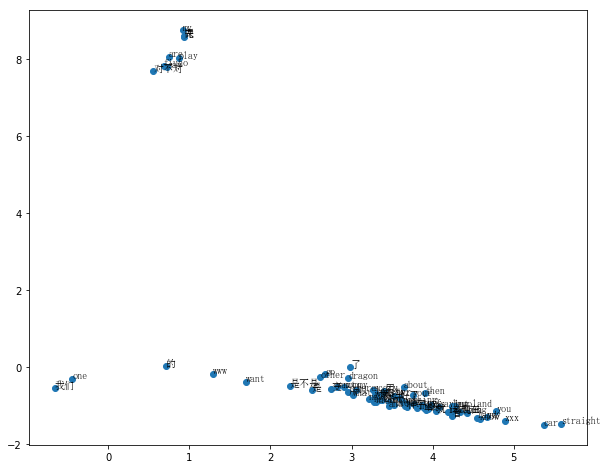

In [124]:
limit = 75

fig, ax = plt.subplots(figsize=(10, 8))
vocab = list(word2vec.wv.vocab.keys())

ax.scatter(wv_2d[:limit, 0], wv_2d[:limit, 1])

for i in range(limit):
    ax.annotate(vocab[i], (wv_2d[i, 0], wv_2d[i, 1]), fontproperties=ChineseFont)

In [132]:
def word_to_index(token):
    if token in word2vec.wv.vocab:
        return word2vec.wv.vocab[token].index
    return -1

def index_to_word(index):
    if index != -1:
        return word2vec.wv.index2word[index]
    return '<OOV>'

def sequence_to_indices(sequence):
    return np.array([word_to_index(t) for t in sequence if word_to_index(t) != -1])

def indices_to_sequence(indices):
    return np.array([index_to_word(i) for i in indices])

print(word_to_index('hello'))
print(index_to_word(word_to_index('hello')))

133
hello


# RNN

- We have raw sentences and need to convert to X, y. 
- X will be sequence_length, and y will be the next word in the sequence
- For each word, we need to convert to its word2vec index. This will be used later on by the Embedding layer (which will contain the vectors).

In [134]:
sequence_len = mean_length//2

X = []
y = []

for seq in tokens:
    # Replace with word2vec indices
    token_indices = sequence_to_indices(seq)
    if len(token_indices) > sequence_len:

        for i in range(len(token_indices)-sequence_len):
            X.append(token_indices[i:i+sequence_len])
            y.append(token_indices[i+sequence_len])
            
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)
print(indices_to_sequence(X[0]), X[0], index_to_word(y[0]), y[0])

(11618, 9) (11618,)
['xxx' 'lea' 'you' 'go' 'to' 'your' 'car' 'race' 'then'] [   0  253    2   35    4   29  246 1555   14] you 2


In [135]:
vocab_size = len(word2vec.wv.vocab)

y_cat = to_categorical(y, vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat)
print(y_train[0])

[0. 0. 0. ... 0. 0. 0.]


In [139]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
from keras.layers import Dropout

print('vocab size', vocab_size)
print('embedding size', word2vec.wv.vector_size)
print('sequence length', sequence_len)

model = Sequential()
model.add(Embedding(vocab_size, word2vec.wv.vector_size,
                    input_length=sequence_len,
                    weights=[word2vec.wv.vectors]))
model.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

vocab size 3144
embedding size 200
sequence length 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 9, 200)            628800    
_________________________________________________________________
lstm_38 (LSTM)               (None, 9, 256)            467968    
_________________________________________________________________
lstm_39 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_22 (Dense)             (None, 3144)              808008    
Total params: 2,430,088
Trainable params: 2,430,088
Non-trainable params: 0
_________________________________________________________________


In [140]:
import time

session = int(time.time())

es = EarlyStopping(patience=2)
mc = ModelCheckpoint('./logs/rnn_singlish/' + str(session) + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                     save_best_only=True)
tb = TensorBoard(log_dir='./logs/rnn_singlish/{}'.format(session))

model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.25,
          callbacks=[tb, mc])

Train on 6534 samples, validate on 2179 samples
Epoch 1/50
6534/6534 [==============================] - 35s 5ms/step - loss: 6.2595 - acc: 0.0517 - val_loss: 6.0103 - val_acc: 0.0620
Epoch 2/50
6534/6534 [==============================] - 31s 5ms/step - loss: 5.7185 - acc: 0.0559 - val_loss: 5.9441 - val_acc: 0.0620
Epoch 3/50
6534/6534 [==============================] - 31s 5ms/step - loss: 5.6151 - acc: 0.0583 - val_loss: 6.1629 - val_acc: 0.0620
Epoch 4/50
6534/6534 [==============================] - 32s 5ms/step - loss: 5.5220 - acc: 0.0577 - val_loss: 5.9387 - val_acc: 0.0468
Epoch 5/50
6534/6534 [==============================] - 30s 5ms/step - loss: 5.4295 - acc: 0.0638 - val_loss: 5.8905 - val_acc: 0.0606
Epoch 6/50
6534/6534 [==============================] - 31s 5ms/step - loss: 5.3308 - acc: 0.0715 - val_loss: 5.9738 - val_acc: 0.0716
Epoch 7/50
6534/6534 [==============================] - 32s 5ms/step - loss: 5.2367 - acc: 0.0782 - val_loss: 5.8441 - val_acc: 0.0698
Epoch 8

In [ ]:
# Tried:
# - More LSTM neurons
# - 2nd LSTM layer
# - Try larger batch size (nope)
# - Try a smaller batch size (better!) 1545101980
# - Train longer 1545101980
# - Try more dense layers (slow but more accurate) 1545102809
# - Larger receptive field
# - Try longer sequence length (better!!) 1545113801 - overfit
# - Dropout(0.1) 1545115134
# - dropout=0.5, recurrent_dropout=0.5 1545115906
# - Drop least frequent words (word_count < 3): min_count = 3 1545120170
# - dropout in multiple RNN layers 1545121438

In [ ]:
# Try different embedding
# Try different optimiser
# Try attention? Does it work with non-seq-to-seq?